In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
ice = pd.read_excel('./iscream(크롤링).xlsx')


In [4]:
#2675로우, 10컬럼
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2675 non-null   int64 
 1   제목          2675 non-null   object
 2   시간          2675 non-null   object
 3   날짜          2675 non-null   object
 4   별점          2675 non-null   int64 
 5   리뷰제목        2675 non-null   object
 6   리뷰내용        2675 non-null   object
 7   연수분야        2675 non-null   object
 8   가격          2675 non-null   object
 9   대상          2675 non-null   object
dtypes: int64(2), object(8)
memory usage: 209.1+ KB


In [5]:
# 'Unnamed: 0' 열 제거
if 'Unnamed: 0' in ice.columns:
    ice = ice.drop(columns=['Unnamed: 0'])

ice = ice.dropna(subset=['별점'])

# 별점 기준 라벨링:5점은 긍정(1), 1-4점은 부정(0)
ice['label'] = ice['별점'].apply(lambda x: 1 if x > 4 else 0)

In [6]:
len(ice[ice['label']=='0'])

0

In [7]:
from konlpy.tag import Okt
okt = Okt()
stop_words = set(['에게','함께','미술','이야기','하면','제','활동','있어서','어떻게','버전','유튜브','페이지','패들렛','사이트','다소','릿','각도','하시','안배','그림','특별','사람','표현','됩니다','평소','강','있게','이번','되고','현장','그림책','참','우리','꼭','있어','있었습니다','연','하는데','아이스크림','하며','하면서','학년','관련','되는','저','여행','게','영어','대해','시간','생각','노션','후기','였습니다','되었습니다','합니다','학기','했습니다','우리나라','너무나','부터','후기','만','통해','화용론','아이','감사합니다','많은','그게','여학생','남학생','듣고','것', '너무','있는','하는','에서','로','더','을','학생','대한','많이','내용','마음','하고','감사','정말','수업','강의','연수','할','수','적','인','분','입니다','의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다'])

In [8]:
def clean_text(text):
    text = re.sub('[^가-힣\s]', '', text)  
    tokens = okt.morphs(text)
    return tokens


ice['tokens'] = ice['리뷰내용'].apply(clean_text)

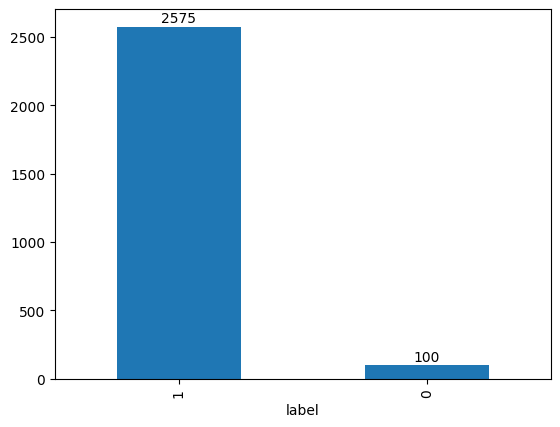

In [9]:
#긍정 2575, 부정100
import matplotlib.pyplot as plt

value_counts = ice['label'].value_counts()

ax = value_counts.plot(kind='bar')


for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

In [10]:
tfidf = TfidfVectorizer()
data_input_reduced= tfidf.fit_transform(ice['리뷰내용'])
data_target = ice['label']


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


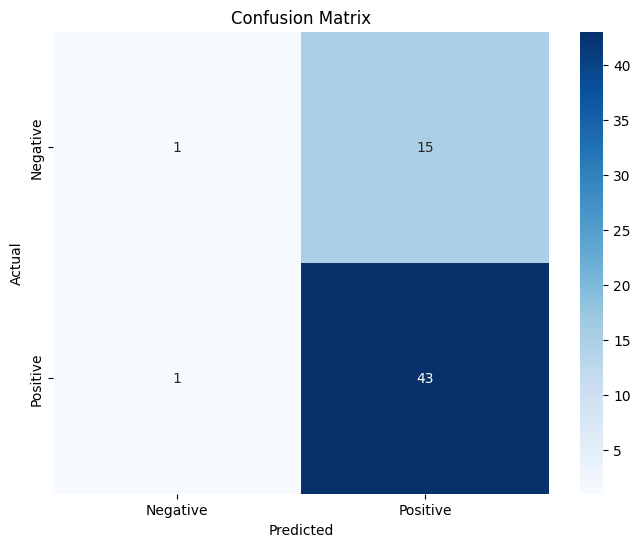

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


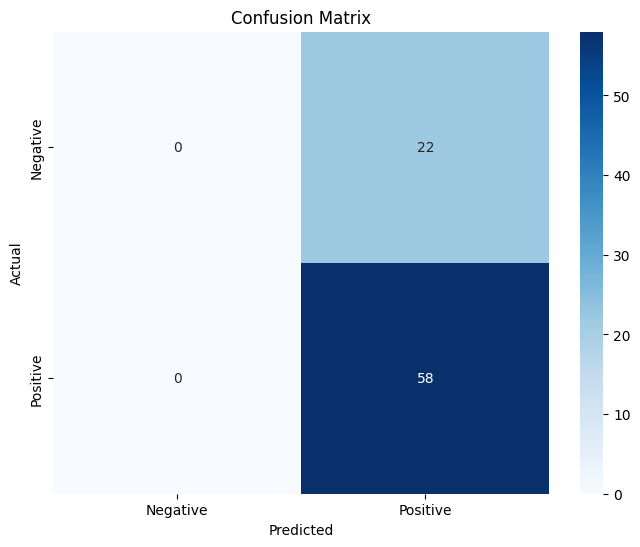

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


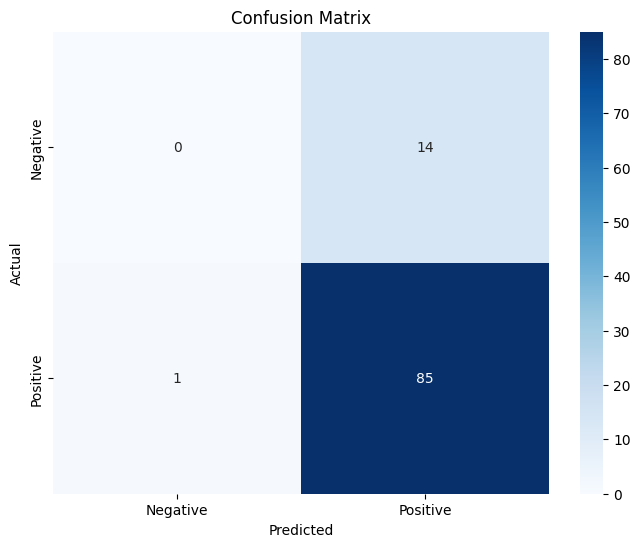

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


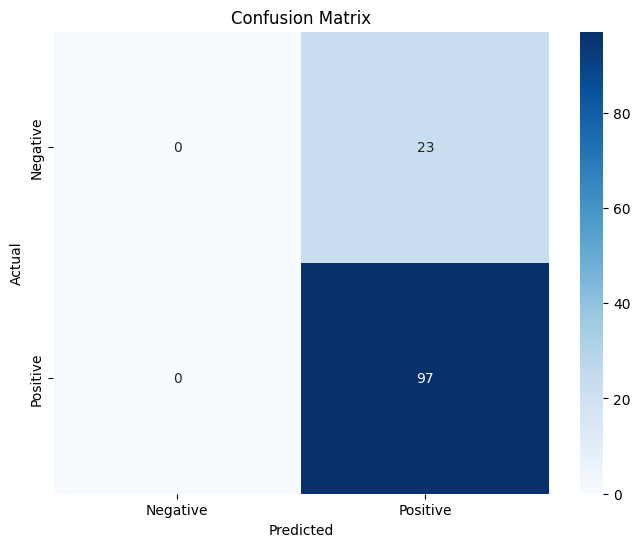

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


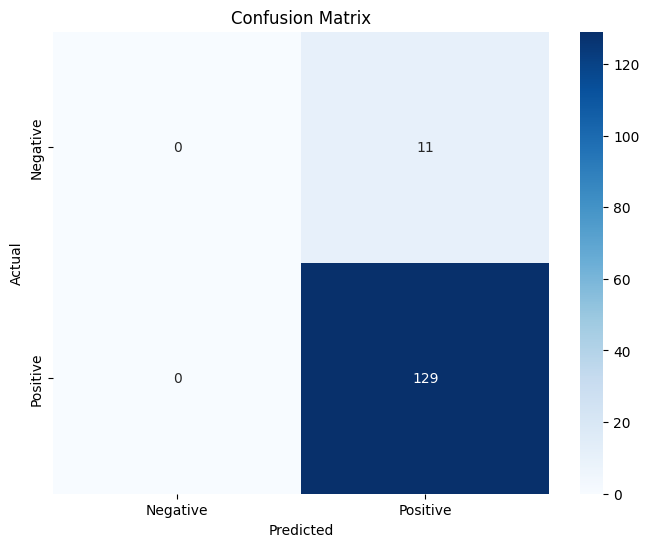

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


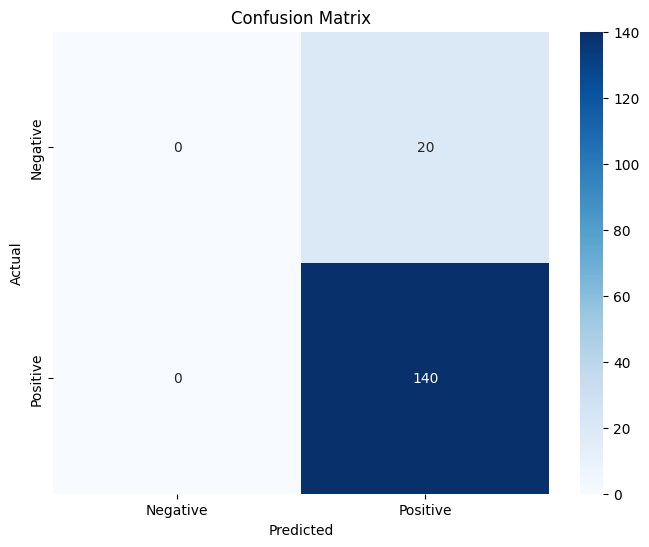

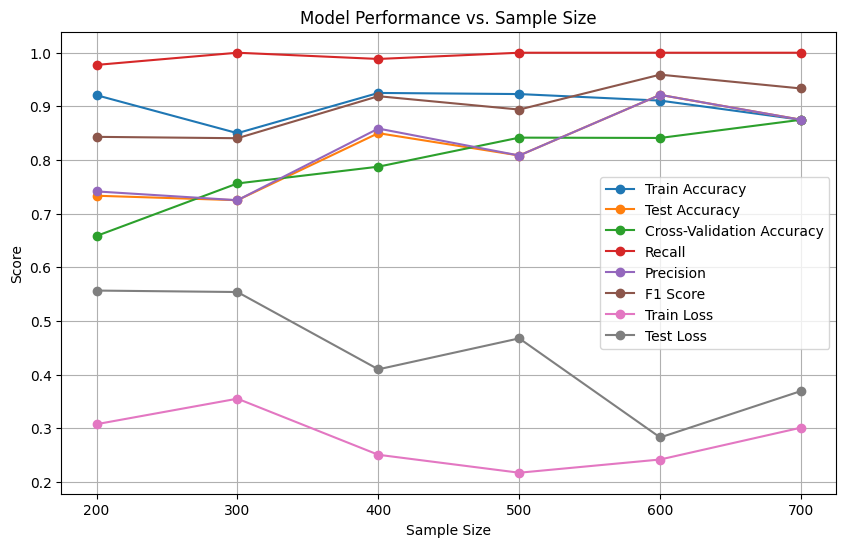

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer


sample_sizes = range(200, 800, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []
precision_results = []
f1_results = []
train_loss_results = []
test_loss_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = ice[ice['label'] == 0]
    Training_data_1 = ice[ice['label'] == 1].sample(size, random_state=41)
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    tfidf = TfidfVectorizer()
    data_input_reduced = tfidf.fit_transform(Undersample_data['리뷰내용'])
    data_target = Undersample_data['label']

    X_train, X_test, y_train, y_test = train_test_split(data_input_reduced, data_target, test_size=0.2, random_state=42)

    # 랜덤 포레스트 모델 정의
    rf = RandomForestClassifier(random_state=42)

    # 그리드 서치 파라미터 설정
    param_grid = {
        'n_estimators': [100, 150, 200],  # 적절한 수의 나무
        'max_depth': [10, 20, 30, 40],    # 최대 깊이 제한
        'min_samples_split': [5, 10, 15], # 분할에 필요한 최소 샘플 수
        'min_samples_leaf': [2, 4, 6],    # 리프 노드에 필요한 최소 샘플 수
        'bootstrap': [True, False]        # 부트스트래핑 여부
    }

    # 그리드 서치 정의
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

    # 그리드 서치 학습
    grid_search.fit(X_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print(f"Best parameters found: {grid_search.best_params_}")

    # 최적 모델로 예측
    best_rf = grid_search.best_estimator_
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # 평가
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_loss = log_loss(y_train, best_rf.predict_proba(X_train))
    test_loss = log_loss(y_test, best_rf.predict_proba(X_test))
    recall = recall_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    cv_accuracy = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy').mean()

    train_accuracy_results.append(train_accuracy)
    test_accuracy_results.append(test_accuracy)
    cv_accuracy_results.append(cv_accuracy)
    recall_results.append(recall)
    precision_results.append(precision)
    f1_results.append(f1)
    train_loss_results.append(train_loss)
    test_loss_results.append(test_loss)

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.plot(sample_sizes, precision_results, marker='o', label='Precision')
plt.plot(sample_sizes, f1_results, marker='o', label='F1 Score')
plt.plot(sample_sizes, train_loss_results, marker='o', label='Train Loss')
plt.plot(sample_sizes, test_loss_results, marker='o', label='Test Loss')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
Undersample_data.to_excel('undersample_data.xlsx', index=False)

In [13]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


# 리뷰내용 컬럼의 모든 텍스트를 가져옴
reviews = ice['리뷰내용'].tolist()

okt = Okt()

# 모든 문서의 명사 추출 후 하나의 텍스트로 결합
processed_docs = []
for doc in reviews:
    nouns = okt.nouns(doc)
    processed_docs.append(" ".join(nouns))

# TF-IDF 벡터화 객체 생성
vectorizer = TfidfVectorizer()

# 텍스트를 TF-IDF로 변환
tfidf_matrix = vectorizer.fit_transform(processed_docs)

# 단어와 그에 대한 TF-IDF 값을 얻기
feature_names = vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# 각 문서의 상위 5개 키워드 추출
top_keywords = []
for doc_index in range(len(reviews)):
    doc_tfidf_values = tfidf_values[doc_index]
    sorted_indices = sorted(range(len(doc_tfidf_values)), key=lambda k: doc_tfidf_values[k], reverse=True)
    top_keywords.append([feature_names[i] for i in sorted_indices[:5]])

# 결과 출력
for i, keywords in enumerate(top_keywords):
    print(f"문서 {i+1}의 상위 키워드: {keywords}")


문서 1의 상위 키워드: ['배기', '쏭쌤', '종대', '알짜', '다음']
문서 2의 상위 키워드: ['글씨', '연습', '교재', '뱃지', '액자']
문서 3의 상위 키워드: ['학력', '소개', '기초', '도움', '사이트']
문서 4의 상위 키워드: ['이슈', '바르게', '이해', '차이', '배경']
문서 5의 상위 키워드: ['일본어', '성우', '양어', '존경어', '사료']
문서 6의 상위 키워드: ['형식', '느낌', '이야기', '강의', '가게']
문서 7의 상위 키워드: ['고전', '부여', '해석', '나름', '의미']
문서 8의 상위 키워드: ['연수', '가게', '가격', '가공', '가기']
문서 9의 상위 키워드: ['교육과정', '토대', '개정', '대략', '교과서']
문서 10의 상위 키워드: ['대비', '직업', '미래', '학생', '대해']
문서 11의 상위 키워드: ['개념', '실제', '대한', '이해', '도움']
문서 12의 상위 키워드: ['미래', '교육', '분야', '생각', '가게']
문서 13의 상위 키워드: ['코이카', '사례', '가게', '가격', '가공']
문서 14의 상위 키워드: ['정재승', '교수', '공부', '시간', '대해']
문서 15의 상위 키워드: ['웹툰', '내용', '이해', '연수', '가게']
문서 16의 상위 키워드: ['잡기', '시민', '개념', '세계', '사례']
문서 17의 상위 키워드: ['열기', '작업', '고학년', '상담', '마음']
문서 18의 상위 키워드: ['원인', '유형', '부진', '별로', '학습']
문서 19의 상위 키워드: ['추천', '연수', '가게', '가격', '가공']
문서 20의 상위 키워드: ['요새', '관심사', '추천', '연수', '가게']
문서 21의 상위 키워드: ['알베르토', '다문화', '교육', '가게', '가격']
문서 22의 상위 키워드: ['생각', '대화', 

Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.88      1.00      0.93       140

    accuracy                           0.88       160
   macro avg       0.44      0.50      0.47       160
weighted avg       0.77      0.88      0.82       160

Positive Reviews (10 examples):
                                                리뷰내용  별점  감정  감정_예측
0  테드 강의 통해서 여러가지 세계 삶의 모습과 영어에 대해서도 배울 수 있었어요.\n...   4   0      1
1                                  바쁜 업무와 일상 속 작은 휴식   5   1      1
2  평소 보드게임을 좋아하시는, 관심있는 선생님들께 강추드리는 연수입니다.\n보드게임을...   5   1      1
3  학습연구년제로 올 1년을 보내면서 자신을 알아가고 있는 중입니다.\n이번 연수를 통...   5   1      1
4  민화를 보는 것을 좋아했지만 직접 그려보는 기회는 없었다. 실제해 보니 작가님처럼 ...   5   1      1
5                 엑셀에 대해 자세하게 배우게 되어, 실무할 때 유용할듯합니다.   5   1      1
6                        의무연수여서 들었는데 재미있게 연수를 받았습니다.   5   1      1
7  매년 영어공부를 해보겠다고 맘은 굴뚝같이 먹지만 실천이 잘 안돼죠~\n올해 또 다짐...   5 

c:\Users\wltjr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wltjr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wltjr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

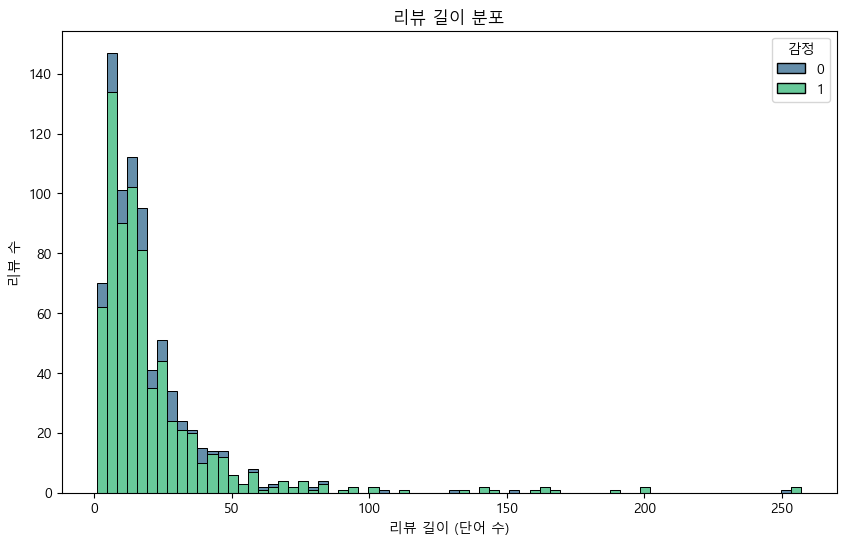

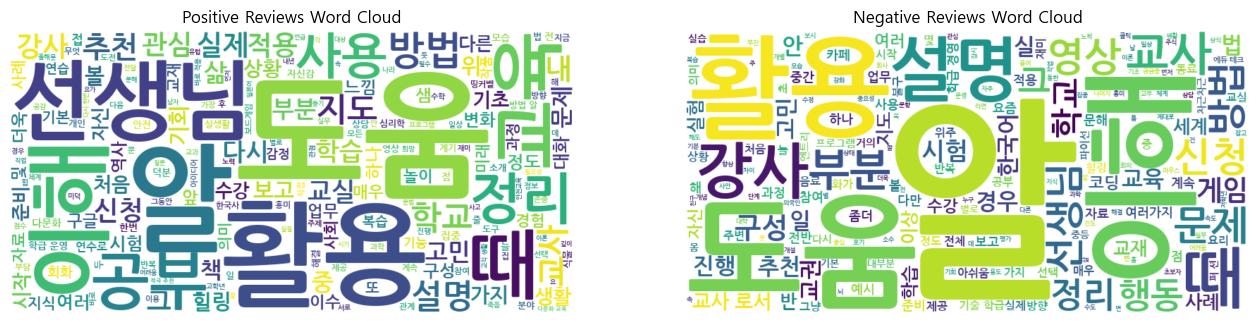

C:\Users\wltjr\AppData\Local\Temp\ipykernel_28616\767918432.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='별점', data=data, palette='viridis')


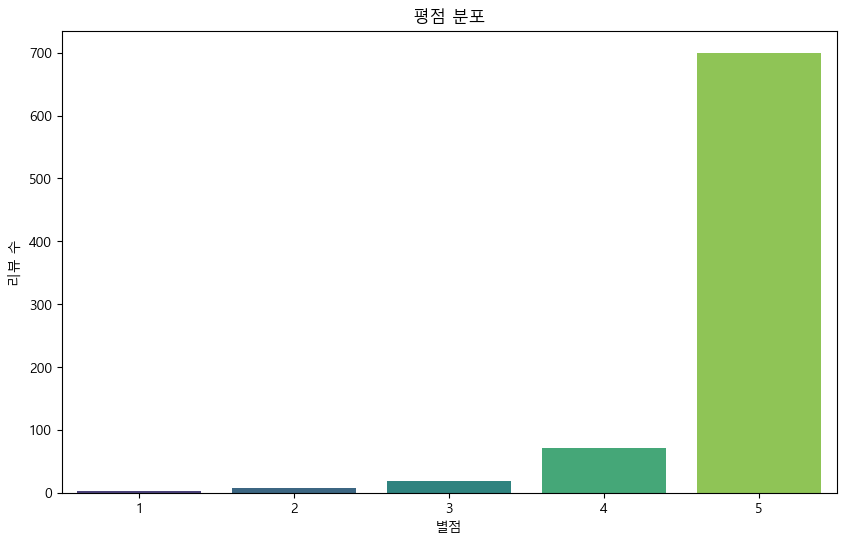

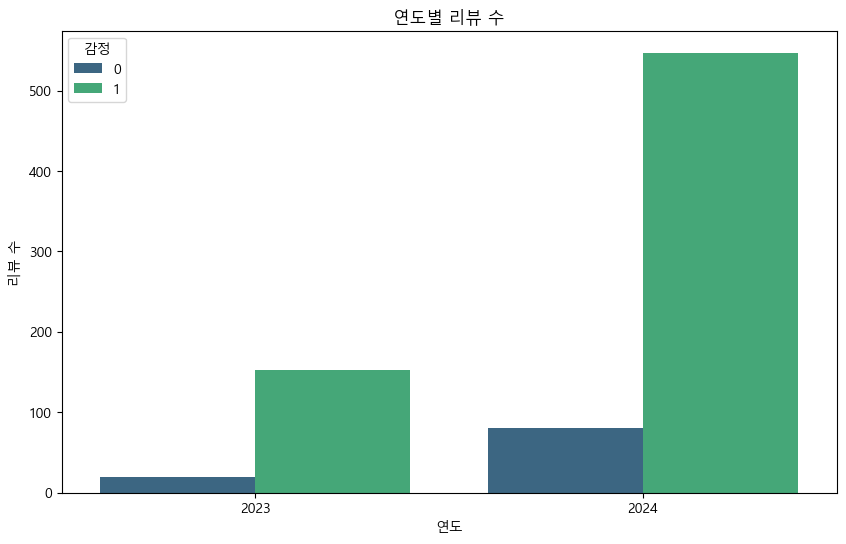

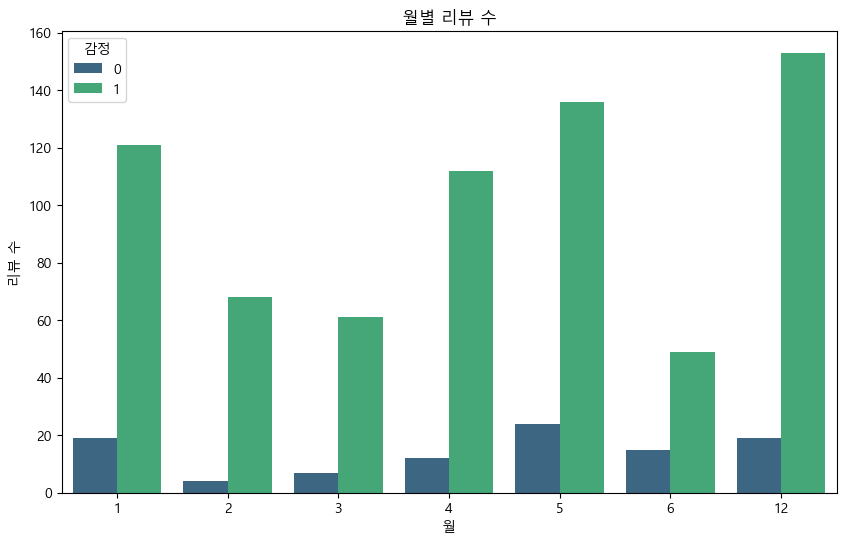

In [14]:
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'D:/0802pj/NanumGothic/29131424179.ttf'  # 한글 폰트 파일 경로 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_name

plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

# 파일을 불러옴
data = pd.read_excel('./undersample_data.xlsx')

# 리뷰 내용에서 '_ x000D' 제거
data['리뷰내용'] = data['리뷰내용'].apply(lambda x: re.sub(r'_x000D_', '', x))

# 감정 라벨 추가 (예시로 긍정=1, 부정=0으로 라벨링)
data['감정'] = data['별점'].apply(lambda x: 1 if x > 4 else 0)

# 리뷰내용 컬럼의 모든 텍스트를 가져옴
reviews = data['리뷰내용'].dropna().tolist()
labels = data['감정'].dropna().tolist()

okt = Okt()
stop_words = set(['때문에', '여학생', '참', '이후', '걍', '활동', '대한', '우리나라', '패들렛', '생각', '하면', '꼭', '제', '하시', '되었습니다', '되면', '감사합니다', '번', '라고', '해서', '을', '표현', '동안', '됩니다', '더', '그러나', '연', '와', '영어', '아주', '자', '아니', '어떻게', '대해', '에', '제일', '어', '페이지', '학생', '하면서', '다소', '같다', '되', '그림', '미술', '등', '함께', '인', '도', '과', '학년', '였습니다', '있어서', '정말', '분', '은', '마음', '된', '릿', '의', '이번', '만', '후기', '버전', '평소', '있는', '하는', '수', '현장', '는지', '서', '했다', '남학생', '그림책', '하며', '지만', '통해', '갔었', '아이', '처럼', '를', '강의', '그래서', '많이', '아직', '모두', '되었', '듣고', '시간', '있게', '여행', '했', '연수', '나', '할', '관련', '입니다', '사람', '잘', '다니', '하는데', '있', '아', '있었습니다', '너', '적', '많은', '는', '하다', '이야기', '학기', '되는', '그리고', '하고', '들', '가', '당신', '로', '조금', '말', '하지만', '안배', '너무', '만큼', '라는', '부터', '그게', '우리', '되고', '위해', '각도', '강', '하', '에서', '너무나', '했습니다', '이', '한', '화용론', '것', '으로', '사이트', '좀', '게', '고', '노션', '예', '에게', '내용', '수업', '유튜브', '저', '특별', '아이스크림', '있어', '감사', '합니다'])

# 모든 문서의 명사 추출 후 불용어 제거 및 결합
processed_docs = []
for doc in reviews:
    nouns = okt.nouns(doc)
    cleaned_nouns = [noun for noun in nouns if noun not in stop_words]
    processed_docs.append(" ".join(cleaned_nouns))

# TF-IDF 벡터화 객체 생성
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_docs)

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 감정 분석 결과 추가
data['감정_예측'] = model.predict(tfidf_matrix)

# 감정 분석 결과 출력 (데이터프레임 형태)
result_df = data[['리뷰내용', '별점', '감정', '감정_예측']]

# 긍정 리뷰 예시 10개
positive_examples = result_df[result_df['감정_예측'] == 1].head(10)

# 부정 리뷰 예시 10개
negative_examples = result_df[result_df['감정_예측'] == 0].head(10)

# 긍정, 부정 리뷰 예시 출력
print("Positive Reviews (10 examples):")
print(positive_examples)

print("\nNegative Reviews (10 examples):")
print(negative_examples)

# 감정 분석 결과와 긍정/부정 리뷰 예시를 데이터프레임으로 저장
result_df.to_excel('sentiment_analysis_results.xlsx', index=False)
positive_examples.to_excel('positive_reviews_examples.xlsx', index=False)
negative_examples.to_excel('negative_reviews_examples.xlsx', index=False)

# 추가 분석

# 리뷰 길이 분석
data['리뷰길이'] = data['리뷰내용'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data, x='리뷰길이', hue='감정', multiple='stack', palette='viridis')
plt.title('리뷰 길이 분포')
plt.xlabel('리뷰 길이 (단어 수)')
plt.ylabel('리뷰 수')
plt.show()

# 워드 클라우드 생성
positive_text = " ".join(nouns for doc, label in zip(processed_docs, labels) if label == 1 for nouns in doc.split())
negative_text = " ".join(nouns for doc, label in zip(processed_docs, labels) if label == 0 for nouns in doc.split())

wordcloud_positive = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(negative_text)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

# 평점 분포 분석
plt.figure(figsize=(10, 6))
sns.countplot(x='별점', data=data, palette='viridis')
plt.title('평점 분포')
plt.xlabel('별점')
plt.ylabel('리뷰 수')
plt.show()

# 리뷰 시간 분석 (가정: '날짜' 컬럼이 있음)
data['날짜'] = pd.to_datetime(data['날짜'])
data['연도'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month

plt.figure(figsize=(10, 6))
sns.countplot(x='연도', hue='감정', data=data, palette='viridis')
plt.title('연도별 리뷰 수')
plt.xlabel('연도')
plt.ylabel('리뷰 수')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='월', hue='감정', data=data, palette='viridis')
plt.title('월별 리뷰 수')
plt.xlabel('월')
plt.ylabel('리뷰 수')
plt.show()


In [15]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

# 파일을 불러옴
data = pd.read_excel('./undersample_data.xlsx')

# label 컬럼에서 값이 5인 것만 필터링
filtered_data = data[data['별점'] != 5]

# 리뷰내용 컬럼의 모든 텍스트를 가져옴
reviews = filtered_data['리뷰내용'].dropna().tolist()

okt = Okt()

# 모든 문서의 명사 추출 후 하나의 텍스트로 결합
processed_docs = []
for doc in reviews:
    nouns = okt.nouns(doc)
    processed_docs.append(" ".join(nouns))

# TF-IDF 벡터화 객체 생성
vectorizer = TfidfVectorizer()

# 텍스트를 TF-IDF로 변환
tfidf_matrix = vectorizer.fit_transform(processed_docs)

# 단어와 그에 대한 TF-IDF 값을 얻기
feature_names = vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# TF-IDF 값을 DataFrame으로 변환
tfidf_df = pd.DataFrame(tfidf_values, columns=feature_names)

# 각 단어의 TF-IDF 값을 합산하여 정렬
tfidf_sum = tfidf_df.sum(axis=0)
sorted_tfidf = tfidf_sum.sort_values(ascending=False)

# 정렬된 TF-IDF 값을 DataFrame으로 변환
sorted_tfidf_df = pd.DataFrame(sorted_tfidf, columns=["TF-IDF"])

# 정렬된 TF-IDF 값을 출력
sorted_tfidf_df.head(20)


,TF-IDF
연수,5.929228
수업,4.352208
강의,4.159614
내용,4.014107
활용,3.975584
대해,3.847027
도움,3.347081
이해,2.906454
대한,2.811643
방법,2.698309


In [16]:
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

# 파일을 불러옴
data = pd.read_excel('./undersample_data.xlsx')

# label 컬럼에서 값이 5인 것만 필터링
filtered_data = data[data['별점'] == 5]

# 리뷰내용 컬럼의 모든 텍스트를 가져옴
reviews = filtered_data['리뷰내용'].dropna().tolist()

okt = Okt()

# 모든 문서의 명사 추출 후 하나의 텍스트로 결합
processed_docs = []
for doc in reviews:
    nouns = okt.nouns(doc)
    processed_docs.append(" ".join(nouns))

# TF-IDF 벡터화 객체 생성
vectorizer = TfidfVectorizer()

# 텍스트를 TF-IDF로 변환
tfidf_matrix = vectorizer.fit_transform(processed_docs)

# 단어와 그에 대한 TF-IDF 값을 얻기
feature_names = vectorizer.get_feature_names_out()
tfidf_values = tfidf_matrix.toarray()

# TF-IDF 값을 DataFrame으로 변환
tfidf_df = pd.DataFrame(tfidf_values, columns=feature_names)

# 각 단어의 TF-IDF 값을 합산하여 정렬
tfidf_sum = tfidf_df.sum(axis=0)
sorted_tfidf = tfidf_sum.sort_values(ascending=False)

# 정렬된 TF-IDF 값을 DataFrame으로 변환
sorted_tfidf_df = pd.DataFrame(sorted_tfidf, columns=["TF-IDF"])

# 정렬된 TF-IDF 값을 출력
sorted_tfidf_df.head(20)


,TF-IDF
연수,70.607637
도움,28.563170
강의,24.238141
수업,23.489606
내용,19.968638
활용,19.419934
생각,17.891380
대해,16.658726
이해,16.637860
학생,15.709841
